<a href="https://colab.research.google.com/github/hikaru122700/kaggle-pub/blob/GCI-titanic/21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
# このセルを実行したあとどうすればいいかがわからない方は、別途配布している、「GoogleColabにおけるドライブのマウントの仕方」と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [69]:
# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# データの読み込み方がわからない方は、別途配布している、GoogleColabにおけるドライブのマウントの仕方、と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。
# path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
path = "/content/drive/My Drive/kaggle/titanic/titanic_data/"

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
# if path == "/content/drive/My Drive/kaggle/titanic/titanic_data/":
    # train.rename(columns={'Survived':'Perished'}, inplace=True)

In [70]:

# 生存数のテーブル作成
male_under16 = train[(train['Sex'] == 'male') & (train['Age'] < 16)]['Survived']
female_pclass3 = train[(train['Sex'] == 'female') & (train['Pclass'] == 3)]['Survived']

print(male_under16.value_counts())
print(female_pclass3.value_counts())


Survived
1    21
0    19
Name: count, dtype: int64
Survived
1    72
0    72
Name: count, dtype: int64


In [71]:

# タイトルをエンジニアリング
train['Title'] = train['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

train['Title'] = train['Title'].replace(
    ["Capt", "Don", "Major", "Col", "Rev", "Dr", "Sir", "Mr", "Jonkheer"], "man"
)
train['Title'] = train['Title'].replace(
    ["Dona", "the Countess", "Mme", "Mlle", "Ms", "Miss", "Lady", "Mrs"], "woman"
)
train['Title'] = train['Title'].replace("Master", "boy")


In [72]:

# "woman-child-groups" をエンジニアリング
train['Surname'] = train['Name'].str.split(',').str[0]
train.loc[train['Title'] == 'man', 'Surname'] = 'noGroup'
train['SurnameFreq'] = train.groupby('Surname')['Surname'].transform('count')
train.loc[train['SurnameFreq'] <= 1, 'Surname'] = 'noGroup'


In [73]:

# "woman-child-group" の生存率を計算
train['SurnameSurvival'] = train.groupby('Surname')['Survived'].transform('mean')
print(train.loc[train['Surname'] != 'noGroup', 'SurnameSurvival'].value_counts())


SurnameSurvival
1.000000    74
0.000000    50
0.750000     8
0.142857     7
0.333333     3
Name: count, dtype: int64


In [74]:

# 全滅する "woman-child-groups"
x_all_perish = train.loc[train['SurnameSurvival'] == 0, 'Surname'].unique()
print(np.sort(x_all_perish))

# 全生存する "woman-child-groups"
x_all_survive = train.loc[train['SurnameSurvival'] == 1, 'Surname'].unique()
print(np.sort(x_all_survive))

# 混合生存の "woman-child-groups"
mixed_survival = train[train['SurnameSurvival'].isin([1/7, 1/3, 3/4])]
print(mixed_survival[['Surname', 'Title', 'Survived']])


['Barbara' 'Boulos' 'Bourke' 'Ford' 'Goodwin' 'Jussila' 'Lefebre'
 'Palsson' 'Panula' 'Rice' 'Sage' 'Skoog' 'Strom' 'Van Impe'
 'Vander Planke' 'Zabour']
['Baclini' 'Becker' 'Brown' 'Caldwell' 'Collyer' 'Coutts' 'Doling'
 'Fortune' 'Goldsmith' 'Graham' 'Hamalainen' 'Harper' 'Hart' 'Hays'
 'Herman' 'Hippach' 'Johnson' 'Kelly' 'Laroche' 'Mellinger' 'Moor'
 'Moubarek' 'Murphy' 'Navratil' 'Newell' 'Nicola-Yarred' 'Peter' 'Quick'
 'Richards' 'Ryerson' 'Sandstrom' 'Taussig' 'West' 'Wick']
       Surname  Title  Survived
25     Asplund  woman         1
68   Andersson  woman         1
119  Andersson  woman         0
182    Asplund    boy         0
233    Asplund  woman         1
261    Asplund    boy         1
297    Allison  woman         0
305    Allison    boy         1
435     Carter  woman         1
498    Allison  woman         0
541  Andersson  woman         0
542  Andersson  woman         0
610  Andersson  woman         0
763     Carter  woman         1
802     Carter    boy         1


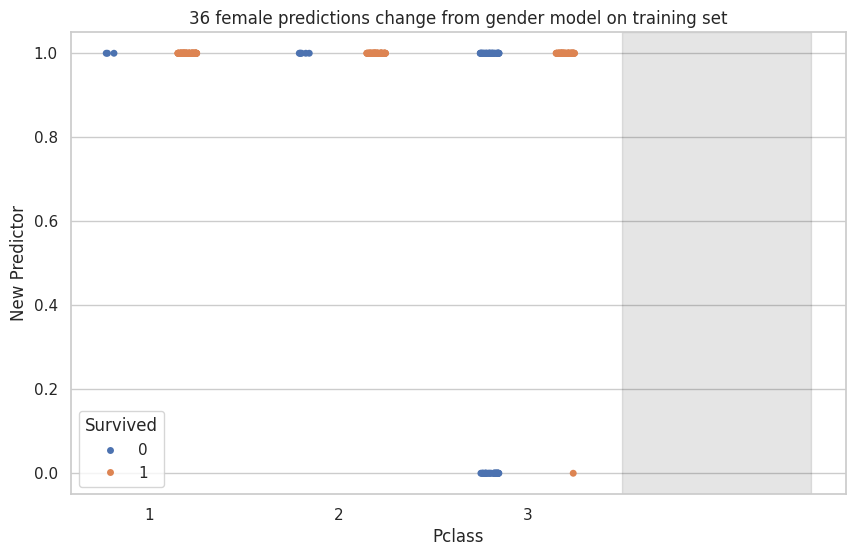

Survived
0    35
1     1
Name: count, dtype: int64


In [75]:

# グラフ描画用ライブラリの設定
sns.set(style="whitegrid")

# 訓練セットで生存率を調整
train['AdjustedSurvival'] = (train['SurnameSurvival'] * train['SurnameFreq'] - train['Survived']) / (train['SurnameFreq'] - 1)

# ジェンダーモデルと新しい予測子を適用
train['predict'] = 0
train.loc[train['Title'] == 'woman', 'predict'] = 1
train.loc[(train['Title'] == 'boy') & (train['AdjustedSurvival'] == 1), 'predict'] = 1
train.loc[(train['Title'] == 'woman') & (train['AdjustedSurvival'] == 0), 'predict'] = 0

# 訓練セットでの予測変更をプロット（sns.stripplotを使用）
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=train[train['Title'] == 'woman'],
    x='Pclass',
    y='predict',
    hue='Survived',
    palette='deep',
    jitter=True,
    dodge=True
)
plt.title("36 female predictions change from gender model on training set")
plt.xlabel("Pclass")
plt.ylabel("New Predictor")
plt.axvspan(2.5, 3.5, color='black', alpha=0.1)
plt.legend(title='Survived')
plt.show()

print(train[(train['Title'] == 'woman') & (train['predict'] == 0)]['Survived'].value_counts())


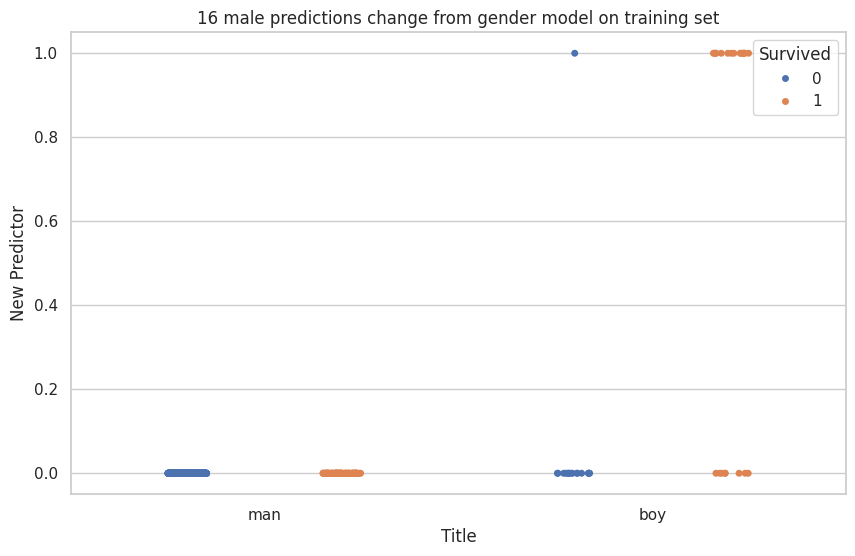

Survived
1    15
0     1
Name: count, dtype: int64


In [76]:

# グラフ描画用ライブラリの設定
sns.set(style="whitegrid")

# ジェンダーモデルと新しい予測子を適用（女性以外）
# 既に 'predict' 列が設定されているため、ここでは何もしません
# train['predict'] = train['predict']  # この行は不要です

# 訓練セットでの予測変更をプロット（女性以外）
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=train[train['Title'] != 'woman'],
    x='Title',
    y='predict',
    hue='Survived',
    palette='deep',
    jitter=True,
    dodge=True
)
plt.title("16 male predictions change from gender model on training set")
plt.xlabel("Title")
plt.ylabel("New Predictor")

# `axvspan` はカテゴリカルデータには適用できないため、削除します
# plt.axvspan(0.5, 1.5, color='black', alpha=0.1)

plt.legend(title='Survived')
plt.show()

print(train[(train['Title'] != 'woman') & (train['predict'] == 1)]['Survived'].value_counts())


In [77]:

# 25回の10-fold交差検証を実施
trials = 25
total_accuracy = 0

for j in range(1, trials + 1):
    x = np.random.permutation(890)
    s = 0
    for i in range(10):
        start = i * 89
        end = start + 89
        test_idx = x[start:end]
        train_subset = train.drop(train.index[test_idx])
        test_subset = train.iloc[test_idx]

        # "woman-child-groups" をエンジニアリング
        train_subset = train_subset.copy()
        train_subset['Surname'] = train_subset['Name'].str.split(',').str[0]
        train_subset.loc[train_subset['Title'] == 'man', 'Surname'] = 'noGroup'
        train_subset['SurnameFreq'] = train_subset.groupby('Surname')['Surname'].transform('count')
        train_subset.loc[train_subset['SurnameFreq'] <= 1, 'Surname'] = 'noGroup'
        train_subset['SurnameSurvival'] = train_subset.groupby('Surname')['Survived'].transform('mean')

        test_subset = test_subset.copy()
        test_subset['Surname'] = test_subset['Name'].str.split(',').str[0]
        test_subset.loc[test_subset['Title'] == 'man', 'Surname'] = 'noGroup'
        test_subset['SurnameFreq'] = test_subset.groupby('Surname')['Surname'].transform('count')
        test_subset.loc[test_subset['SurnameFreq'] <= 1, 'Surname'] = 'noGroup'

        # テストセットの SurnameSurvival をトレーニングセットから取得
        try:
            train_mapping = train_subset[['Surname', 'SurnameSurvival']].drop_duplicates().set_index('Surname')['SurnameSurvival']
            test_subset['SurnameSurvival'] = test_subset['Surname'].map(train_mapping)
        except Exception as e:
            print(f"Error during mapping in Trial {j}, Fold {i+1}: {e}")
            test_subset['SurnameSurvival'] = np.nan

        # 'noGroup' または NaN の場合に適切な値を設定（例えば、全体の平均生存率）
        overall_survival_rate = train_subset['Survived'].mean()
        test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)

        # ジェンダーモデルと新しい予測子を適用
        test_subset['predict'] = 0
        test_subset.loc[test_subset['Title'] == 'woman', 'predict'] = 1
        test_subset.loc[(test_subset['Title'] == 'boy') & (test_subset['SurnameSurvival'] == 1), 'predict'] = 1
        test_subset.loc[(test_subset['Title'] == 'woman') & (test_subset['SurnameSurvival'] == 0), 'predict'] = 0

        # 誤差の計算
        c = np.sum(np.abs(test_subset['predict'] - test_subset['Survived']))
        s += c

    accuracy = 1 - s / 890
    print(f"Trial {j} has 10-fold CV accuracy = {accuracy:.6f}")
    total_accuracy += accuracy

average_accuracy = total_accuracy / trials
print(f"Average 10-fold CV accuracy from {trials} trials = {average_accuracy:.6f}")

Trial 1 has 10-fold CV accuracy = 0.788764


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 2 has 10-fold CV accuracy = 0.788764


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 3 has 10-fold CV accuracy = 0.789888


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 4 has 10-fold CV accuracy = 0.793258


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 5 has 10-fold CV accuracy = 0.791011


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 6 has 10-fold CV accuracy = 0.787640


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 7 has 10-fold CV accuracy = 0.787640


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 8 has 10-fold CV accuracy = 0.793258


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 9 has 10-fold CV accuracy = 0.786517


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 10 has 10-fold CV accuracy = 0.792135


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 11 has 10-fold CV accuracy = 0.787640


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 12 has 10-fold CV accuracy = 0.789888


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 13 has 10-fold CV accuracy = 0.789888


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 14 has 10-fold CV accuracy = 0.788764


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 15 has 10-fold CV accuracy = 0.792135


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 16 has 10-fold CV accuracy = 0.788764


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 17 has 10-fold CV accuracy = 0.789888


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 18 has 10-fold CV accuracy = 0.792135


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 19 has 10-fold CV accuracy = 0.793258


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 20 has 10-fold CV accuracy = 0.787640


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 21 has 10-fold CV accuracy = 0.788764


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 22 has 10-fold CV accuracy = 0.788764
Trial 23 has 10-fold CV accuracy = 0.791011


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Trial 24 has 10-fold CV accuracy = 0.786517
Trial 25 has 10-fold CV accuracy = 0.792135
Average 10-fold CV accuracy from 25 trials = 0.789843


<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_subset['SurnameSurvival'].fillna(overall_survival_rate, inplace=True)
<ipython-input-77-3ce7383389ee>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [78]:

# テストデータセットでタイトルをエンジニアリング
test['Title'] = test['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

test['Title'] = test['Title'].replace(
    ["Capt", "Don", "Major", "Col", "Rev", "Dr", "Sir", "Mr", "Jonkheer"], "man"
)
test['Title'] = test['Title'].replace(
    ["Dona", "the Countess", "Mme", "Mlle", "Ms", "Miss", "Lady", "Mrs"], "woman"
)
test['Title'] = test['Title'].replace("Master", "boy")


In [79]:

# "woman-child-groups" をエンジニアリング
test['Survived'] = np.nan
test['predict'] = np.nan
train.drop(['AdjustedSurvival', 'Surname', 'SurnameFreq', 'SurnameSurvival'], axis=1, inplace=True)

allData = pd.concat([train, test], ignore_index=True)

allData['Surname'] = allData['Name'].str.split(',').str[0]
allData.loc[allData['Title'] == 'man', 'Surname'] = 'noGroup'
allData['SurnameFreq'] = allData.groupby('Surname')['Surname'].transform('count')
allData.loc[allData['SurnameFreq'] <= 1, 'Surname'] = 'noGroup'

# "Name" のみでグループを補正
for i in allData[(allData['Title'] != 'man') & (allData['Surname'] == 'noGroup')].index:
    matching_ticket = allData[allData['Ticket'] == allData.at[i, 'Ticket']]
    if not matching_ticket.empty:
        allData.at[i, 'Surname'] = matching_ticket.iloc[0]['Surname']
allData['Surname'].fillna('noGroup', inplace=True)

# "woman-child-group" の生存率を計算
allData['SurnameSurvival'] = np.nan
allData.loc[:890, 'SurnameSurvival'] = allData.loc[:890].groupby('Surname')['Survived'].transform('mean')

for i in range(891, len(allData)):
    surname = allData.at[i, 'Surname']
    survival_rate = allData.loc[:890][allData['Surname'] == surname]['SurnameSurvival'].dropna()
    if not survival_rate.empty:
        allData.at[i, 'SurnameSurvival'] = survival_rate.iloc[0]
    else:
        allData.at[i, 'SurnameSurvival'] = np.nan

# ジェンダーモデルと新しい予測子を適用
allData['predict'] = 0
allData.loc[allData['Title'] == 'woman', 'predict'] = 1
allData.loc[(allData['Title'] == 'boy') & (allData['SurnameSurvival'] == 1), 'predict'] = 1
allData.loc[(allData['Title'] == 'woman') & (allData['SurnameSurvival'] == 0), 'predict'] = 0


<ipython-input-79-274c5763ab46>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  allData['Surname'].fillna('noGroup', inplace=True)
<ipython-input-79-274c5763ab46>:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survival_rate = allData.loc[:890][allData['Surname'] == surname]['SurnameSurvival'].dropna()
<ipython-input-79-274c5763ab46>:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survival_rate = allData.loc[:890][allData['Surname'] == surname]['SurnameSurvi

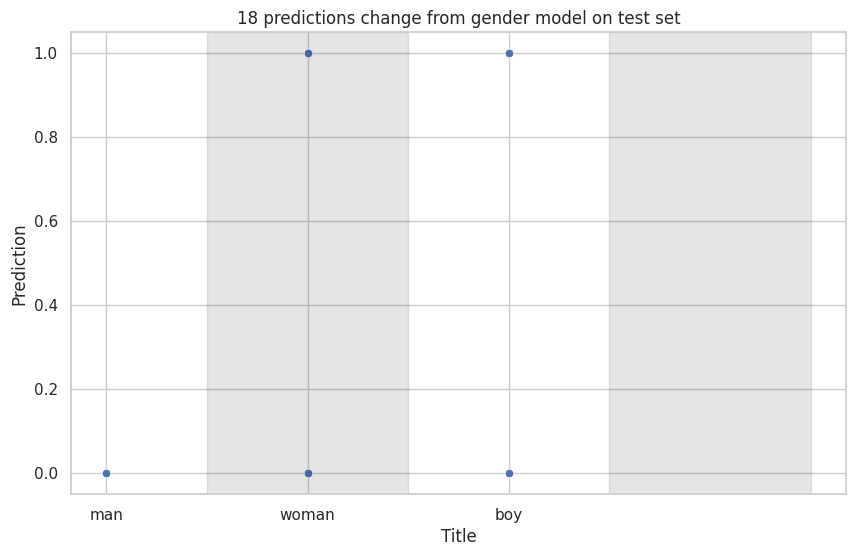

In [80]:

# テストセットでの予測をプロット
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=allData.iloc[891:1309],
    x='Title',
    y='predict'
)
plt.title("18 predictions change from gender model on test set")
plt.xlabel("Title")
plt.ylabel("Prediction")
plt.axvspan(0.5, 1.5, color='black', alpha=0.1)
plt.axvspan(2.5, 3.5, color='black', alpha=0.1)
plt.show()


In [81]:
 # 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
submission = pd.read_csv(path + 'gender_submission.csv')
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [82]:
if path ==  "/content/drive/My Drive/松尾研/GCI/コンペ１/":
    submission["Perished"] = allData.loc[891:1308, 'predict']
else:
    submission["Survived"] = allData.loc[891:1308, 'predict']

print(submission)
#  もしkaggleに提出する場合は以下のコードを実行す
# submission.rename(columns={'Perished': 'Survived'}, inplace=True)
submission

     PassengerId  Survived
0            892       NaN
1            893       NaN
2            894       NaN
3            895       NaN
4            896       NaN
..           ...       ...
413         1305       NaN
414         1306       NaN
415         1307       NaN
416         1308       NaN
417         1309       NaN

[418 rows x 2 columns]


,PassengerId,Survived
0,892,NaN
1,893,NaN
2,894,NaN
3,895,NaN
4,896,NaN
...,...,...
413,1305,NaN
414,1306,NaN
415,1307,NaN
416,1308,NaN


In [83]:

# 提出用CSVファイルを作成
submit = pd.DataFrame({
    'PassengerId': allData.loc[891:1308, 'PassengerId'],
    'Survived': allData.loc[891:1308, 'predict']
})
submit.to_csv("genderSurnameModel.csv", index=False)

In [84]:
# Google Drive・Google Colaboratoryで作業する場

if submission.columns[1] == 'Survived':
    submission.to_csv('submission_to_kaggle_titanic.csv', index=False)
    path = "/content/drive/My Drive/松尾研/GCI/コンペ１/"
    correct = pd.read_csv(path + 'correct.csv')
    ans = 0
    for i in range(len(correct)):
      if correct['Survived'][i] == submission['Survived'][i]:
            ans += 1
    print(f"あなたの正解率は{ans/len(correct)}です")
else:
    faile_name = "19.csv"
    submission.to_csv(faile_name,index=False)
    print(submission)
    print(f"{faile_name}をOmnicampusに提出してください")

# from google.colab import files
# files.download('submission.csv')

あなたの正解率は0.0です
